## Kernel Density Estimation



### The Wiggly Distribution



We address the following problem.  There exists a random variable
with a density $f$.  We call this distribution the &ldquo;wiggly&rdquo;
distribution, and use the magic of `scipy.stats` to define it as follows:



In [1]:
from scipy.stats import rv_continuous
import numpy as np

class wiggly_gen(rv_continuous):

    """Wiggly distribution"""

    def _pdf(self, x):
        d = self.b - self.a
        return (np.sin(x*6*2*np.pi/d) + 1)/(self.b - self.a)

wiggly = wiggly_gen(a=0.,b=2*np.pi,name='wiggly')

x = wiggly()

f = x.pdf  # Name of true pdf, for pedagogical convenience

Check that it&rsquo;s valid&#x2014;does $f$ integrate to one?



In [2]:
from scipy.integrate import quad

quad(f,0,2*np.pi)

(1.0000000000000002, 1.1102230246251569e-14)

Plot the pdf:



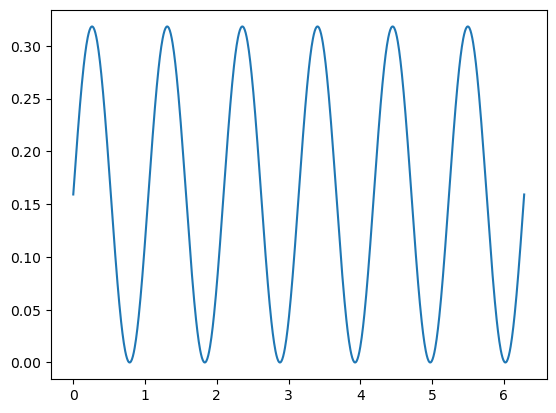

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_pdf(x,npts=1000,ax=None):

    if ax is None:
        fig,ax = plt.subplots()

    V = np.linspace(x.a,x.b,npts)
    ax.plot(V,[x.pdf(v) for v in V])

    return ax

ax = plot_pdf(x)

### Sample



Now, suppose we don&rsquo;t know the distribution of the random variable
$x$, but we can draw a sample of realizations, which we&rsquo;ll put in a `pandas.Series`.



In [4]:
import pandas as pd

n = 1000 # Sample size

S = pd.Series(x.rvs(size=n))

### Estimation



How can we use this random sample to estimate the density?
One simple idea is to look at the histogram (scaled to sum to one):



<Axes: >

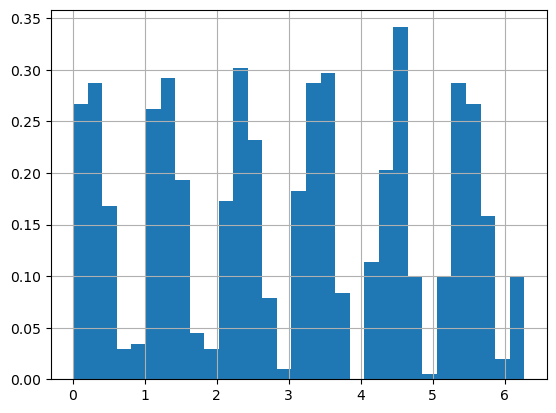

In [5]:
S.hist(bins=int(np.sqrt(len(S))),density=True)

This captures some of the important features of the distribution, but
let&rsquo;s see if we can do better by using kernel density tools.

Start by defining a kernel:



In [6]:
sqrt3 = np.sqrt(3)  # Avoid repeated evaluation of this for speed...

k = lambda u: (np.abs(u) < sqrt3)/(2*sqrt3)  # Rectangular kernel

# k = lambda u: np.exp(-(u**2)/2)/np.sqrt(2*np.pi) # Gaussian kernel

Now define the kernel estimator:



In [7]:
def kernel_estimator(X,h):
    """
    Use data X to estimate a density, using bandwidth h.
    """
    return lambda x: k((X-x)/h).mean()/h

We already have a random sample: let&rsquo;s try using it to estimate $f$:



In [8]:
fhat = kernel_estimator(S,0.05) 

fhat(1)  # Try to evaluate at a point

0.13279056191361394

Now graph our estimate



In [ ]:
ax = plot_pdf(x) # "True" distribution

V = np.linspace(0,2*np.pi,100)

ax.plot(V,[fhat(x) for x in V])

Play with other bandwidths, and compare with &ldquo;truth&rdquo;



In [ ]:
ax = plot_pdf(x) # "True" distribution

fhat = kernel_estimator(S,0.25) 

ax.plot(V,[fhat(x) for x in V])

Consider the Silverman rule of thumb:



In [ ]:
h_silverman = S.std()*S.count()**(-1/5)*1.06

ax = plot_pdf(x) # "True" distribution

fhat = kernel_estimator(S,h_silverman) 

ax.plot(V,[fhat(x) for x in V])

### Bias



Hansen (Probability, &sect; 17.4) develops an expression for the bias of
the  kernel density estimator:
$$
  \mbox{Bias}(x) = \int k(u)\left(f(x+hu)-f(x)\right)du.
$$
Thus, bias depends only on the kernel, the bandwidth, and the
(unknown!) density $f$.

Here we use an &ldquo;oracle&rdquo; estimator to estimate the bias, in which we
make use of the fact that (for the experiment in this notebook) we in
fact *do* do know $f$.



#### Oracle Bias Estimator



In [ ]:
from scipy.integrate import quad # General purpose integration

integrand = lambda u,x,h: k(u)*(f(x + h*u) - f(x))

# bias will return a pair (integral,absolute error tolerance),
# where the latter is a promise that the absolute error 
# from numerical integration is smaller than the reported tolerance.
bias = lambda x,h: quad(lambda u: integrand(u,x,h), # Hold x & h fixed in integral
                        a=0, b=2*np.pi)   # Limits of integration

Try evaluating this:



In [ ]:
bias(x=1,h=0.1)

Try plotting!



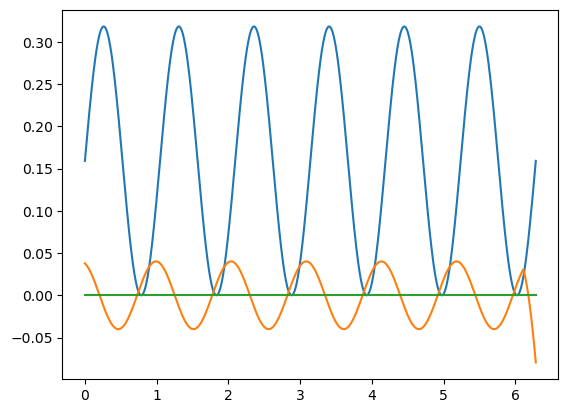

In [15]:
ax = plot_pdf(x)
h = 0.1
ax.plot(V,[bias(v,h=h) for v in V])

Compare with actual estimate:



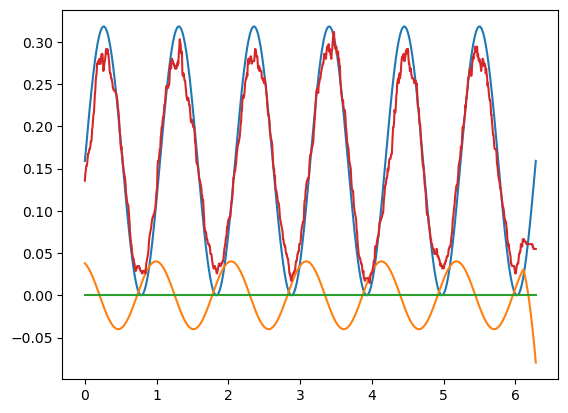

In [17]:
ax = plot_pdf(x)

h = 0.1

fhat = kernel_estimator(S,h=h) 

ax.plot(V,[bias(v,h=h) for v in V])

ax.plot(V,[fhat(v) for v in V])

### Variance



The finite-sample *variance* of the kernel estimator (so now sampling
variation matters) can be computed as just the variance of the sample
&ldquo;smooths&rdquo; $k(x_i - x)/h$, so



In [1]:
def Vhat(X,h):
    """
    Use data X to estimate the variance of $\hat{f}$ as a function of $x$.
    """
    n = X.count()
    return lambda x: k((X-x)/h).var()/(n*h**2)

Try evaluating this:



In [1]:
vhat = Vhat(S,h=0.1)  # Remember S is a sample!

Try plotting!



In [1]:
plt.plot(V,[vhat(v) for v in V])